# NWL Fire Emissions Article
### Analysis of emissions due to fires and comparison with carbon flux estimates from literature
By Oriana Chegwidden

In [5]:
import matplotlib.pyplot as plt
import xarray as xr
import regionmask

import numpy as np
import h5py
import fsspec
import pandas as pd
from tqdm import tqdm
C_TO_CO2_CONVERSION = 3.66
import json
import gcsfs
import numcodecs
from gfed import return_gfed_emissions
# Update this to where you're working!
work_dir = '/home/jovyan/blogposts/nwl-california-forests/analyses/'

# Calculate fire emissions based on GFED

In [12]:
CO2_df, full_ds = return_gfed_emissions(start_year=2000, end_year=2021, return_spatial=True)

  0%|          | 0/22 [00:00<?, ?it/s]/srv/conda/envs/notebook/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:
100%|██████████| 22/22 [02:15<00:00,  6.16s/it]


In [70]:
write_spatial=False
if write_spatial:
    storage_options = {'verify_ssl': False}
    fs = gcsfs.GCSFileSystem()
    cloud_bucket = 'gs://carbonplan-nwl'
    encoding = {'emissions MMT CO2/year': {'compressor': numcodecs.Blosc()}}
    store = fsspec.get_mapper(cloud_bucket+'/data/GFED_annual_emissions_CO2.zarr')
#     store = gcsfs.GCSFileSystem.get_mapper(root=cloud_bucket+'/data/GFED_emissions.zarr')
    full_ds.to_zarr(store, mode='w', encoding=encoding)

In [ ]:
def date_format(date):
    """
    Convert time label to the format of pandas line plot
    """
    return f'{date.year}'

# Total greenhouse gas emisisons from California Air Resources Board

Load in CARB GHG Emissions Inventory from https://ww3.arb.ca.gov/cc/inventory/pubs/reports/2000_2018/ghg_inventory_trends_00-18.pdf

In [13]:
ghg_california_emissions_carb = pd.read_excel('{}/2000_2019_ghg_inventory_trends_figures.xlsx'.format(work_dir))
ghg_california_emissions_carb = pd.Series(list(ghg_california_emissions_carb.loc[4].values[2:]), 
                                          index=pd.date_range('2000','2020',freq='Y'))

# Collate the greenhouse gas and fire emissions estimates

Initialize the dataframe with fires.

In [14]:
full_emissions_df = pd.DataFrame(CO2_df, columns=['Fire (GFED)'])

Since 2019 is the most recent year for which we have GHG estimates we'll just assume the emissions for 2020-2021 were the same as 2019. We know that this assumption has error, largely due to the COVID-19 pandemic, but these numbers will largely be used for illustrative purposes and do not expect any updates to change the overall story.

In [15]:
full_emissions_df['Anthropogenic GHG Inventory'] = ghg_california_emissions_carb

Forward fill 2020 and 2021 with 2019 estimates for GHG inventory

In [16]:
full_emissions_df.iloc[-1, 1] = full_emissions_df.iloc[-3, 1]
full_emissions_df.iloc[-2, 1] = full_emissions_df.iloc[-3, 1]

Then add in CARB's fire estimates from CARB's _Wildfire Emission Estimates for 2020_. See also https://ww3.arb.ca.gov/cc/inventory/pubs/ghg_emissions_forest_management_webinar_slides.pdf

In [17]:
carb_fire = pd.read_csv('{}/carb_wildfire_estimates_2020.txt'.format(work_dir),\
            header=None)
carb_fire = pd.Series(carb_fire[1].values, index=pd.date_range('2000', '2021', freq='Y'))
full_emissions_df['Fire (CARB)'] = carb_fire

In [18]:
full_emissions_df.head()

,Fire (GFED),Anthropogenic GHG Inventory,Fire (CARB)
2000-12-31,6.571791,468.0,5.4
2001-12-31,6.057294,483.1,6.2
2002-12-31,6.971701,482.7,13.5
2003-12-31,7.649050,482.8,18.3
2004-12-31,5.993434,490.8,5.2


Then load in the carbon stock info from NWL inventory

In [19]:
# # Load in the ts of stocks (which is in units of MMT C)
# # CARB definition for Forests and Other Natural Lands (FONL) includes dead organic matter (DOM)


# carb_fonl_stocks = pd.read_csv('{}/carb_fonl_stocks.csv'.format(work_dir), header=None)
# dates = ['2001-12-31', '2010-12-31', '2012-12-31', '2014-12-31']
# index = pd.to_datetime(dates, format='%Y-%m-%S')
# idx = pd.date_range('2002', '2014', freq='Y')

# carb_fonl_stocks = pd.Series(carb_fonl_stocks[1].values, index=index) * C_TO_CO2_CONVERSION
# # Interpolate to gapfill and then do delta to calculate the loss in stock in that year
# # and turn it negative since we'll be treating lost stock to be an emission
# carb_fonl_stock_emissions = -carb_fonl_stocks.resample('A').sum().replace({0:np.nan}).interpolate().diff()

We also have an estimate from Holland et al (2019) which says that forests sequestered (net) XX MMT over a ten year period. Let's assume that becomes a X.X MMT/year constant value for comparison's sake.

In [20]:
# full_emissions_df['Net (Holland et al 2019)'] = X.X

In [21]:
#full_emissions_df['CARB Stock Emisisons'] = carb_fonl_stock_emissions
# and then (just as a guess- this could be suspect) we can estimate "sequestration" by removing fire
# full_emissions_df['Sequestration (CARB)'] = full_emissions_df['Net (Holland et al 2019)'] - full_emissions_df['Fire (CARB)']

Let's first just write out a df with just the variables for the blog post we're considering right now. Jeremy will use this to make a nice set of initial figures.

In [21]:
full_emissions_df.to_csv('{}/emissions.csv'.format(work_dir))

# Figure 1: How do California's GHG emissions compare to their 2020 target set by AB32 (431 MMT CO2)

Text(0, 0.5, 'CO2 Emissions [MMT]')

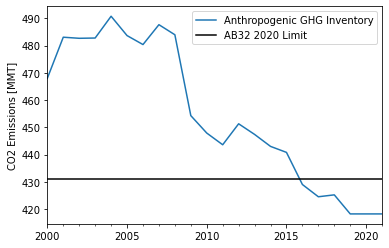

In [22]:
full_emissions_df[[
                'Anthropogenic GHG Inventory',
                  ]].plot()
plt.axhline(431, color='k', label='AB32 2020 Limit')
plt.legend()
plt.ylabel('CO2 Emissions [MMT]')

From the above plot it might like a big reduction in emissions but if we zero-out the y-axis we see that emissions reductions aren't that significant percentage-wise.

(0.0, 494.43)

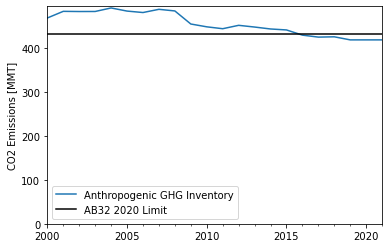

In [23]:
full_emissions_df[[
                'Anthropogenic GHG Inventory',
                  ]].plot()
plt.axhline(431, color='k', label='AB32 2020 Limit')
plt.ylabel('CO2 Emissions [MMT]')
plt.legend()
plt.ylim(0)

We'll write out these numbers to creat our web article.

In [23]:
figure1_json = {}
figure1_json['ghg_inventory'] = np.array([full_emissions_df.index.year.values, 
                  full_emissions_df[['Anthropogenic GHG Inventory']].values.squeeze()]).transpose().tolist()
figure1_json['AB32'] = 431 # The target for 
with open('figure1.json', "w") as outfile:
    json.dump(figure1_json, outfile)

# Figure 2: What about fire emissions? 

What do fire emissions look like over time? CARB provides estimates, but they haven't yet released 2021's estimates. Let's use GFED to get a preview. And along the way, let's compare the estimates to see how they might differ.

Text(0, 0.5, 'CO2 Emissions [MMT]')

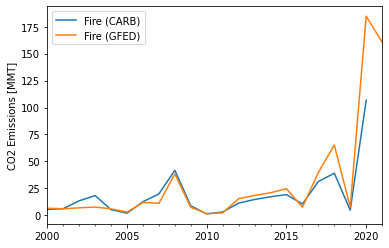

In [25]:
fig, ax = plt.subplots()
full_emissions_df[[
                'Fire (CARB)',
                'Fire (GFED)'
                  ]].plot(ax=ax)
# plt.text(0.04, 0.76, '*Note 2021 GFED estimates for Jan-Sep', transform=ax.transAxes)
plt.ylabel('CO2 Emissions [MMT]')

And let's write out those numbers to JSON

In [72]:
figure2_json = {}
for dataset in ['Fire (CARB)', 'Fire (GFED)']:
    figure2_json[dataset] = np.array([full_emissions_df.index.year.values, 
                  full_emissions_df[[dataset]].values.squeeze()]).transpose().tolist()
with open('figure2.json', "w") as outfile:
    json.dump(figure2_json, outfile)

In [103]:
# copernicus = pd.Series([14.3, 5.8, 4, 13.6, 18.2, 10.9, 8.6, 2.9, 
# 3.5, 11.3, 9.2, 10.1, 16.1, 13.4, 17.8, 14.7, 5, 41.8], index=pd.date_range('2003', '2021', freq='Y'))

In [104]:
# full_emissions_df['Copernicus'] = copernicus * C_TO_CO2_CONVERSION

In [13]:
# full_emissions_df[[
#                 'Fire (CARB)',
#                 'Fire (GFED)',
#     'Copernicus'
#                   ]].plot()
# plt.ylabel('CO2 Emissions [MMT]')

Now let's do some accounting calculations. This is just going to be a handful of numbers but I _promise_ it's going to be really interesting.

In [2]:
50/10.5

4.761904761904762

First we initialize our different time periods that we'll average over.

Then we'll grab the different AGC estimates from the literature. This is all laid out really nicely in the Holland et al (2019) paper.

# Calculating the appropriate time periods to match the estimates in the literature

Calculating emissions based upon annual timeseries and differences between multiyear averages are different methods. Thus, it can be tricky to align annual emissions timeseries with emissions calculated based upon stock-difference approaches from multiyear averages of FIA data. Based upon understandings of FIA inventory approaches we will assume that fluxes calculated by comparing inventories from two periods, (start1-start2) and (end1-end2) will be representative of average fluxes from (start2-end2) exclusive. We spell out the details of those assumptions below.

Confusing things to tease apart:
* what pools
* what time periods
* what fire
time period alignment: 
* if FIA period sampling - sampling time period (start_year - end_year) we assume the end_year is the year it is representative of. conceptually, we can say that if a fire went through in an earlier year we would have captured that loss in carbon.
* now we have a year0 and year1 for stock change estimates.
* in aligning the stock change estimates with fire emissions we use emissions from the years after that time period ends. as an example, christensen et al 2001-2011 carbon flux estimates we'll align with fires 2002-2011 inclusive.
* for gonzalex et al it is more simple example since they use landfire- their time periods are 2001-2010


To clarify:
* try to conform to only forests, use all of the different options (ex: all NWL from christensen, gonzalez et al - trees only?)
* include all NWL # from holland et al -leaning toward no because its a composite of other datasets and time periods get super tricky
* time periods: christensen use 2006-2015 for the (2001-2005) and (2011-2015) estimates. 
* gonzalez paper says 2001-2010 is 9 years but holland et al divides by 10 to get annualized estimates

# Collate estimates from the literature

The literature includes a range of estimates of forest carbon fluxes. Here we collect them, note their provenance, keep track of the time periods which they cover, and note any nuances for each data source.

### AB 1504 California Forest Ecosystem and Harvested Wood Product Carbon Inventory

First, estimates from Christensen et al. _AB 1504 California Forest Ecosystem and Harvested Wood Product Carbon Inventory: 2017 Reporting Period. Final Report._ Febraury 13, 2019.
    
The estimates below are in MMT CO2e and do not include contributions from the harvested wood products. They released updated these numbers twice with additional reports (releasing reports in 2015, 2016, and 2017). Holland et al (described below) reference the numbers from the 2015 report.

In [1]:
christensen = {
              '2015': 32.8, #+-5.5 MMT CO2e
              '2016': 30.7, #+-5.3 MMT CO2e
              '2017': 27. #+-5.5MMT CO2e}
              }

We can look at the numbers in MMT of C as well. 

In [5]:
for year, co2 in christensen.items():
    print(f'In {year} the estimated carbon update was {co2/C_TO_CO2_CONVERSION} MMT C')

In 2015 the estimated carbon update was 8.96174863387978 MMT C
In 2016 the estimated carbon update was 8.387978142076502 MMT C
In 2017 the estimated carbon update was 7.377049180327869 MMT C


3.66

grayson comment - Would it be at all useful to report the whole period sequestration vs whole period fire emission? So you could do 29.2 MMTCO2 * nyears and compare that to the sum of GFED emissions. In other words 2021 has already undone ~5 years of carbon sequestration. 2020 undid something like six years?

In [37]:
# all slices here are INCLUSIVE
net_options = {
#                     'holland_et_al_2019_single_years': {'value': -6.3,
#                                                       'range': slice('2002', '2011')}, # single years (10 years) 
                    'holland_et_al_2019_periods': {'value': -4.5,
                                                   'range': slice('2007', '2016')}, # periods (10 years)- this is the number they go with at the end
#                         'holland_et_al_2019_allNWL': {'value': -2.7,
#                                                       'range': slice('2001', '2010')}, # calculated for (2001-2005) to (2011-2015)
                      'gonzalez_et_al_2015': {'value': -4.8, # trees only # also available: wildland ecosystems (-6.9), trees and shrubland (-7.1)
                                                      'range': slice('2002', '2010')}, # all land excluding crops and settlements
                      'carb_2015': {'value': -6.5, # AB1504 2015 estimate for standing live tree
                                                 # 
                                                 'range': slice('2006', '2015')},
#                           'carb_2016': {'value': -22.285/C_TO_CO2_CONVERSION, # AB1504 2016 estimate for standing live tree
#                                                  # 
#                                                  'range': slice('2007', '2016')},
#                               'carb_2017': {'value': -14.847/C_TO_CO2_CONVERSION, # AB1504 2015 estimate for standing live tree
#                                                  # 
#                                                  'range': slice('2008', '2017')},
# *** 2018 report seems to have typos - don't know if it's actually 2019?
                              'carb_2019': {'value': -13.091/C_TO_CO2_CONVERSION, # AB1504 2015 estimate for standing live tree
                                                 # 
                                                 'range': slice('2010', '2019')},
                        
#                     'AB_1504': {'value': -7.98, # -29.2 / C_TO_CO2_CONVERSION
#                                 'range': slice('2004', '2014')} # (plots measured (2001-2007) compared to (2011-2017)
                      }

In [7]:
net_options_json = {
                    'holland_et_al_2019_periods': {'value': -4.5 * C_TO_CO2_CONVERSION,
                                                      'range': [2007,2016]},
                      'gonzalez_et_al_2015': {'value': 4.8 * C_TO_CO2_CONVERSION,
                                                      'range': [2002,2010]}, # all land excluding crops and settlements
                      'ab1504_2015': {'value': -6.5 * C_TO_CO2_CONVERSION, 
                                                 'range': [2006,2015]},# they only did trees so it's a little hard to compare
                    'ab1504_2019': {'value': -3.58 * C_TO_CO2_CONVERSION, # -13.091/C_TO_CO2_CONVERSION
                                'range': [2010,2019]} # (plots measured (2001-2007) compared to (2011-2017)
                      }

In [9]:
net_options_json

{'holland_et_al_2019_periods': {'value': -16.47, 'range': [2007, 2016]},
 'gonzalez_et_al_2015': {'value': 17.568, 'range': [2002, 2010]},
 'ab1504_2015': {'value': -23.79, 'range': [2006, 2015]},
 'ab1504_2019': {'value': -13.1028, 'range': [2010, 2019]}}

In [31]:
# net_options_json = {
#                     'holland_et_al_2019_forestonly': {'value': -4.5,
#                                                       'range': [2004,2014]},
#                         'holland_et_al_2019_allNWL': {'value': -2.7,
#                                                       'range': [2001,2010]},# calculated for (2001-2005) to (2011-2015)
#                       'gonzalez_et_al_2015': {'value': 6.9,
#                                                       'range': [2001,2010]}, # all land excluding crops and settlements
#                       'christensen_et_al_2017': {'value': -6.5, 
#                                                  'range': [2006,2015]},# they only did trees so it's a little hard to compare
#                     'AB_1504': {'value': -7.98, # -29.2 / C_TO_CO2_CONVERSION
#                                 'range': [2004,2014]} # (plots measured (2001-2007) compared to (2011-2017)
#                       }

In [8]:
with open('figure3.json', "w") as outfile:
    json.dump(net_options_json, outfile)

In [6]:
with open('figure3.json', "r") as outfile:
    ds = json.load(outfile)

In [13]:
figure3_json = {}
net_effects = []
for net_citation, net_value in net_options.items():
    net_effects.append([net_citation, net_value * C_TO_CO2_CONVERSION])
figure3_json['net effect options'] = net_effects
figure3_json['fire effect options'] = figure2_json
with open('figure3.json', "w") as outfile:
    json.dump(figure3_json, outfile)

NameError: name 'figure2_json' is not defined

So the values above represent the net effect of forests from the sources and sinks from California vegetation. We also have emissions due to fires calculated in two different ways by CARB and GFED above. We'll first translate the AGC vegetation effects into CO2 and then subtract out our fire emissions to get the non-fire effect. We'll assume that this is largely due to vegetation sequestration. It will likely be low-biased as we do not remove any effects of droughts or insect (esp. bark beetle) effects. It's worthwhile to note that Holland et al (2019) stress that while the remote sensing based techniques are more highly biased when doing inventory analysis for growth they _are_ useful for change mapping (like is done in by the CARB/GFED estimates!). So, we're essentially trusting the robust estimates from Holland et al (2019) do a good growth model, but then remove a credible fire emissions effect.

AB 1504 did another inventory analysis and found (p3): 
```Based on plots initially measured between 2001-2007 and re-measured between 2011- 2017, the average statewide rate of forest carbon sequestration is 29.2 ± 4.9 MMT CO2e per year, excluding net CO2e contributions from other sources such as, harvested wood products, forest land conversions and non-CO2 GHG emissions from wildfire (Table 4.1, 4.3).```

In [15]:
 29.2/C_TO_CO2_CONVERSION

7.978142076502731

In [8]:
net_options

{'holland_et_al_2019_single_years': {'value': -6.3,
  'range': slice('2002', '2011', None)},
 'holland_et_al_2019_periods': {'value': -4.5,
  'range': slice('2007', '2016', None)},
 'gonzalez_et_al_2015': {'value': -4.8, 'range': slice('2002', '2010', None)},
 'christensen_et_al_2017': {'value': -6.5,
  'range': slice('2006', '2015', None)}}

Since Holland et al (2019) calculated it based upon changes in stocks between (2001-2005) and (2011-2015), we should align with them in our fire analyses to maintain consistency. So, we'll do 2001-2015.

In [27]:
accounting_method = 'christensen_et_al_2017'#'AB_1504'#'holland_et_al_2019_allNWL'
fire_method = 'Fire (CARB)'#'Fire (GFED)'#'Fire (CARB)'## #

In [30]:
fire_effect = full_emissions_df[fire_method].loc[net_options[accounting_method]['range']].mean()
net_effect = net_options[accounting_method]['value'] * C_TO_CO2_CONVERSION
vegetation_uptake = net_effect - fire_effect

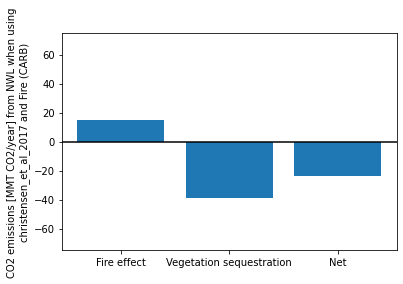

In [31]:
plt.bar(['Fire effect',
         'Vegetation sequestration',
         'Net'], np.array([fire_effect, vegetation_uptake, net_effect]))
plt.ylabel('CO2 emissions [MMT CO2/year] from NWL when using\n'
            '{} and {}'.format(accounting_method, fire_method))
plt.ylim(-75, 75)
plt.axhline(0, color='k')

Now we'll assume the vegetation sequestration is the same. We don't really know for sure (it's so tricky to figure out) but we'll just assume that since Holland et al (2019) did a good job we'll trust them. But we'll sub in the average annual fire effect like it's been for the past 15 years and update the net effect.

In [32]:
fire_effect = full_emissions_df[fire_method].truncate(before='2015', after='2021').mean()
net_effect = vegetation_uptake + fire_effect

In [33]:
net_effect

-3.5033333333333303

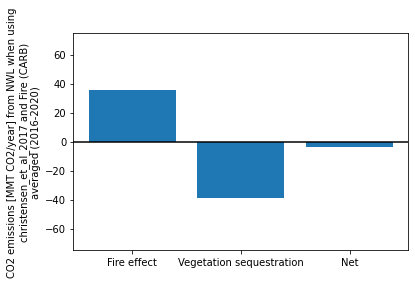

In [34]:
plt.bar(['Fire effect',
         'Vegetation sequestration',
         'Net'], np.array([fire_effect, vegetation_uptake, net_effect]))
plt.ylabel('CO2 emissions [MMT CO2/year] from NWL when using\n'
            '{} and {}\naveraged (2016-2020)'.format(accounting_method, fire_method))
plt.ylim(-75,75)
plt.axhline(0, color='k')

Caveats:

    * assumes no effect of a giant regrowth due to large fires in later part of record

Instead if we took the vegetation sequestration from Christensen and applied the fire estimates we could also create an updated net effect.

Now let's add the "net emissions" assuming constant vegetation sequestration and variable fire effects to each year of the GHG inventory.

In [21]:
full_emissions_df['Vegetation sequestration'] = vegetation_uptake
full_emissions_df['Net forest effect'] = full_emissions_df[fire_method] + full_emissions_df['Vegetation sequestration']
full_emissions_df['Anthropogenic + Forests GHG Inventory'] = full_emissions_df['Anthropogenic GHG Inventory']+\
                                        full_emissions_df['Net forest effect']

(0.0, 496.27670363636366)

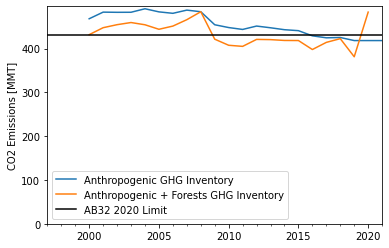

In [22]:
full_emissions_df[[
                'Anthropogenic GHG Inventory', 'Anthropogenic + Forests GHG Inventory'
                  ]].plot()

plt.axhline(431, color='k', label='AB32 2020 Limit')
plt.ylabel('CO2 Emissions [MMT]')
plt.legend()
plt.ylim(0)